# Testing Mouth Open/Close Detection

In [1]:
from commonfunctions import *
import math
from skimage import filters
from skimage import data
from skimage.color import rgb2gray

import skfuzzy as fuzz
import dlib

%matplotlib inline
%load_ext autoreload
%autoreload 2

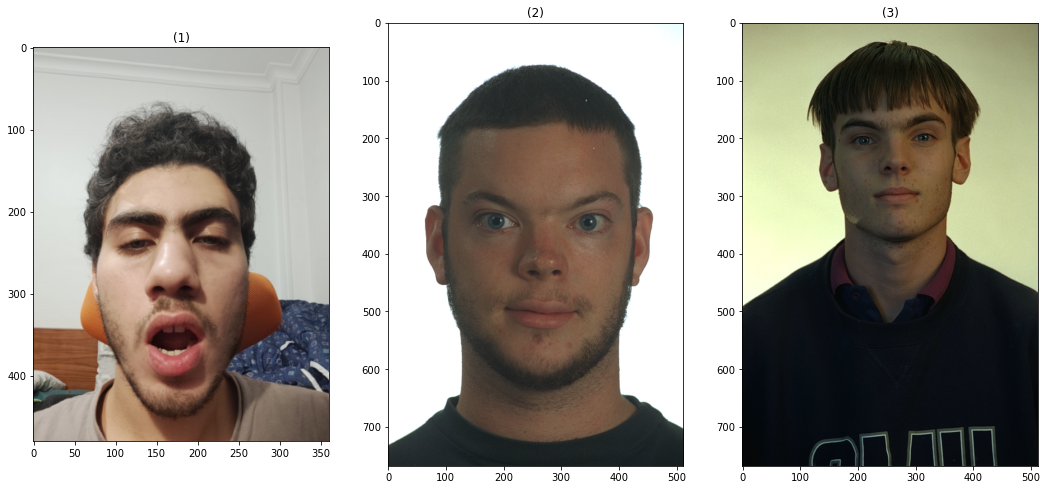

In [2]:


img_open = io.imread('./test_images/me3.jpg')
img_open = (resize(img_open,(480,360,3),anti_aliasing=True)*255).astype("uint8")
 


img_sample = io.imread('./test_images/colorferet_3.ppm')
img_sample2=io.imread("./test_images/colorferet_1.ppm")


show_images([img_open, img_sample,img_sample2])

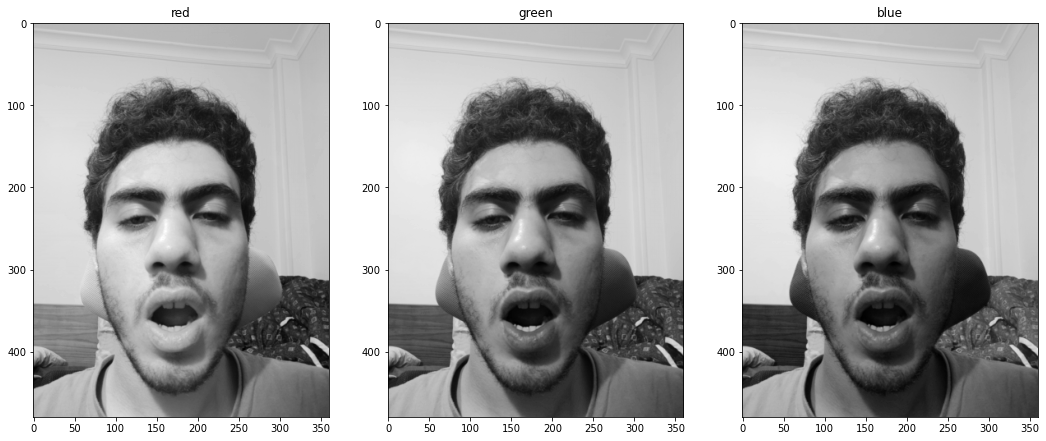

In [3]:
show_images([img_open[:,:,0],img_open[:,:,1],img_open[:,:,2]],["red","green","blue"])

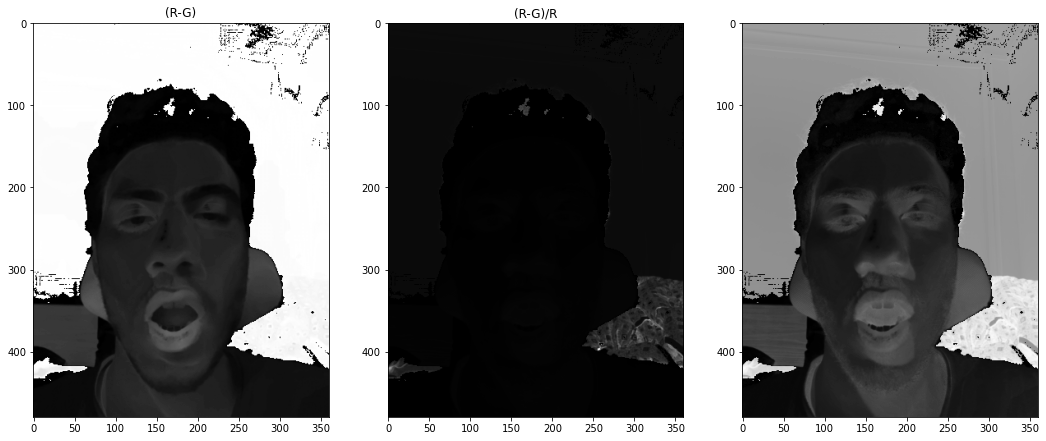

In [28]:
show_images([(img_open[:,:,0]-img_open[:,:,1]),(img_open[:,:,0]-img_open[:,:,1])/img_open[:,:,0],2*np.arctan((img_open[:,:,0]-img_open[:,:,1])/img_open[:,:,0])/np.pi],["(R-G)","(R-G)/R",""])

In [4]:
def detectMouth(img):
    # detect face:
    detector = dlib.get_frontal_face_detector()
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))

    face = img[d.top():d.bottom(), d.left():d.right()]
    dimensions_face=face.shape
    mouth = face[int(dimensions_face[0]/2+(0.05*(d.bottom()-d.top()))):,:,:]


    quarter_face=mouth.shape[1]//4
    mouth= mouth[:,quarter_face:quarter_face*3,:]

    dimensions_mouth=mouth.shape

    io.imshow(face)
    io.imshow(mouth)
    io.show()
    return mouth , dimensions_mouth

In [5]:
def PixelsCount(image):
    return image.shape[0]*image.shape[1]

In [6]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [7]:
def selectLipRegion(mouth, dimensions_mouth):
    R = mouth[:,:,0]
    G = mouth[:,:,1]

    print(mouth.shape)
    # calculate chromatism
    chromatism = 2 * np.arctan((R-G)/R) / np.pi

    io.imshow(chromatism)
    io.show()
    chromatism = chromatism.reshape(-1,1)

    sorted_chromatism = -np.sort(-chromatism,axis=None,)

    chromatism_mouth_perc = int(chromatism.shape[0] * 0.15)
    print("15 percent :",chromatism_mouth_perc)
    chromatsim_largest_twenty=sorted_chromatism[0:chromatism_mouth_perc]


    chromatism = chromatism.reshape(dimensions_mouth[0],dimensions_mouth[1])
    io.imshow(chromatism)
    io.show()

    #print(chromatism in chromatsim_largest_twenty)
    new_img = np.zeros(dimensions_mouth)

    # for i in range(0,dimensions_mouth[0]):
    #     for j in range(0,dimensions_mouth[1]):
    #         if chromatism[i,j] in chromatsim_largest_twenty:
    #             new_img[i,j]=255
    #         else:
    #             new_img[i,j]=0

    for chromatism_val in chromatsim_largest_twenty:
        temp = chromatism==chromatism_val
        new_img[temp] =255

    #new_img = chromatism[x for x in chromatsim_largest_twenty]
    io.imshow(new_img)
    io.show()

    return new_img


In [8]:
def contourIntersect(contour1, contour2):
    intersection = cv2.pointPolygonTest(contour1,(int(contour2[0][0][0]),int(contour2[0][0][1])),False)
    return intersection

In [17]:
def getROI(mouth):

    #showing contours
    temp = np.zeros_like(mouth)
    temp2 = np.zeros_like(mouth)
    #one connected component or 2 connected component
    connected = True  

    # get 2 largest contours 
    largest_two_cnts=contours[0:2]  
    print(cv2.contourArea(largest_two_cnts[0]))
    cv2.drawContours(temp, largest_two_cnts, -1, (255,0,0), 1) #draw all contours
    cv2.drawContours(temp2, contours, -1, (255,0,0), 1) #draw all contours
    
    show_images([temp2,temp],["All contours","2 largest cnts"])


    #if 2 components are nested , inside = 1 , else , components are not connected
    inside = contourIntersect(largest_two_cnts[0],largest_two_cnts[1])   

    if inside>0:
        connected=True
    else:
        connected=False

    if connected: # if connected , draw bounding rect for largest (outer contour)
        x,y,w,h = cv2.boundingRect(largest_two_cnts[0])
        cv2.rectangle(temp,(x,y),(x+w,y+h),(255,255,255),1)
        print("connected ",x,y,w,h)
        ROI = mouth_open[max(2,y-int(0.10*mouth.shape[0])):min(int(y+h+int(0.10*mouth.shape[0])),mouth.shape[0]),max(2,x-int(0.2*mouth.shape[1])):min(mouth.shape[1],x+w+int(0.2*mouth.shape[1])),:]
    else:   #else , draw bounding rect for both region
        x1,y1,w1,h1 = cv2.boundingRect(largest_two_cnts[0])     
        cv2.rectangle(temp,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

        x2,y2,w2,h2 = cv2.boundingRect(largest_two_cnts[1])
        cv2.rectangle(temp,(x2,y2),(x2+w2,y2+h2),(255,255,255),1)

        print("area difference : ",cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1])," 1/2 pf largest :" ,int(0.4*cv2.contourArea(largest_two_cnts[0])))           
        if cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1]) > 400:      #if the size of second largest is negligible in comparison to first , discard it
            print("not connected ",x1,y1,w1,h1)
            ROI = mouth_open[max(2,y1-int(0.10*mouth.shape[0])):min(mouth.shape[0],y1+h1+int(0.10*mouth.shape[0])),max(2,x1-int(0.2*mouth.shape[1])):min(mouth.shape[1],x1+w1+int(0.2*mouth.shape[1])),:]
        else:
            minx=min([x1,x2])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
            maxx=max([x1+w1,x2+w2])
            miny=min([y1,y2])
            maxy=max([y1+h1,y2+h2])
            print("not connected ",miny,maxy,minx,maxx)
            ROI = mouth_open[max(2,miny-int(0.10*mouth.shape[0])):min(mouth.shape[0],maxy+int(0.10*mouth.shape[0])),max(2,minx-int(0.2*mouth.shape[1])):min(mouth.shape[1],maxx+int(0.2*mouth.shape[1])),:]         #retrieve ROI

    return ROI

Number of faces detected: 1
Detection 0: Left: 68 Top: 167 Right: 291 Bottom: 390


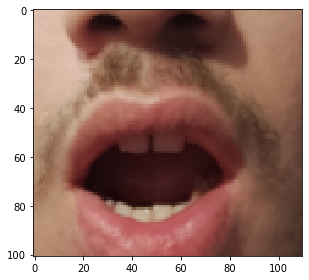

here
(101, 110, 3)


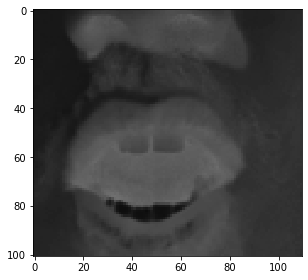

15 percent : 1666


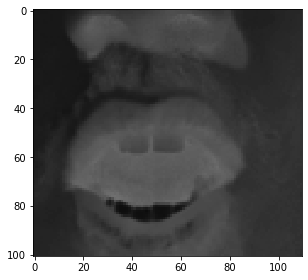

c:\Users\myass\anaconda3\envs\gp\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


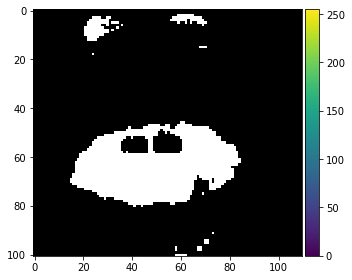

<class 'numpy.uint8'>


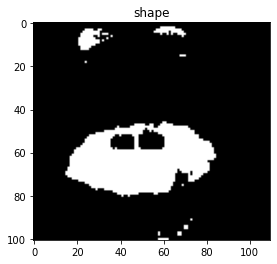

In [18]:
mouth_open , dim_open = detectMouth(img_open)
print("here")
mouth = selectLipRegion(mouth_open, dim_open)
mouth = np.uint8( rgb2gray(mouth) *255 ) 

print(type(mouth[0][0]))

show_images([mouth],["shape"])



contours, hierarchy = cv2.findContours(mouth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [19]:
contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area

1605.5


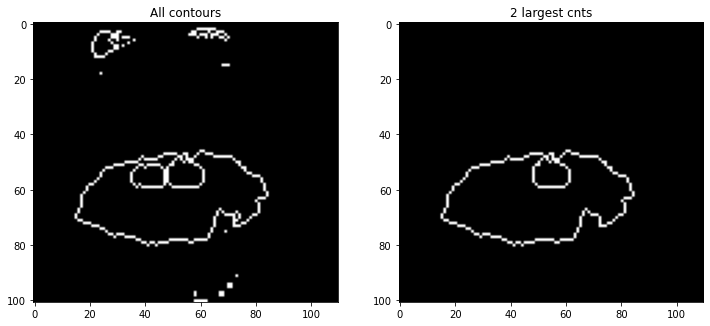

area difference :  1495.5  1/2 pf largest : 642
not connected  15 46 70 35


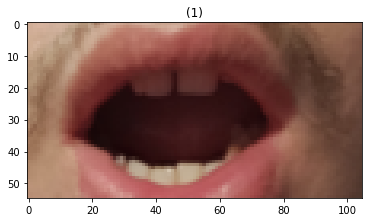

In [20]:
# cv2.drawContours(temp, contours, 0, (255,0,0), 1) #draw all contours
# show_images([temp])

ROI = getROI(mouth)

show_images([ROI])


# Find mouth contours


**approach 1 - RGB based**

(42, 108, 3)
number pixels : 4536
skin value : 4036
n : 302
iteration : 1
Threshold [27]


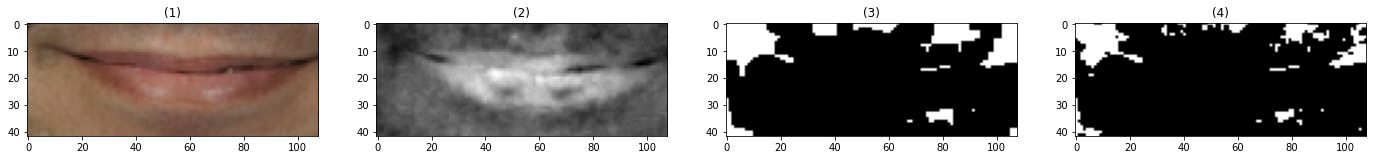

In [64]:
#calculate threshold T for segmentation

print(ROI.shape)

#calculate R - G 
red_minus_green = ROI[:,:,0]-ROI[:,:,1]

skin_value=0
n=0
new_img=np.zeros((ROI.shape[0],ROI.shape[1]))
k=0 #debug

while skin_value <= int((1/20)*PixelsCount(new_img)):
    #reshape R - G  to a vector
    red_minus_green_vector = red_minus_green.reshape(-1,1)

    top_10 = int(0.1*red_minus_green_vector.shape[0])  # top 10% pixels number in R-G values


    red_minus_green_sorted = sorted(red_minus_green_vector)  # ascendigly sort R_G values
    red_minus_green_top_10_plus_n = red_minus_green_sorted[0:top_10+n]   # pick smallest 10% values + n

    red_minus_green = red_minus_green.reshape(ROI.shape[0],ROI.shape[1])    #rstore the vector into an image again 

    new_img = red_minus_green == red_minus_green_top_10_plus_n[0]  # set pixels having value equal to top value to 1  

    for i in range(1,top_10+n):       #repeat for the top 10% values in R-G
        new_img |= red_minus_green == red_minus_green_top_10_plus_n[i] 

    new_img = np.uint8(new_img*255)  #convert float to uint
    new_img = closing(new_img,selem=square(5))  #perform a closing operation to remove gaps

    contours, hierarchy = cv2.findContours(new_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area

    largest_two_cnts=contours[0:2]
    x1,y1,w1,h1 = cv2.boundingRect(largest_two_cnts[0])     

    #cv2.rectangle(new_img,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

    minx=min([x1])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
    maxx=max([x1+w1])
    miny=min([y1])
    maxy=max([y1+h1])

    mouth_region = new_img[miny:maxy,minx:maxx]

    skin_value = PixelsCount(new_img)-PixelsCount(mouth_region)

    n += int( (1/15)*PixelsCount(new_img) )
    k+=1

    print("number pixels :",PixelsCount(new_img))
    print("skin value :" ,skin_value)
    print("n :" , n)
    print("iteration :" , k)

T = red_minus_green_top_10_plus_n[-1]

print("Threshold",T) 

final_image = np.zeros((red_minus_green.shape[0],red_minus_green.shape[1]))

for i in range(red_minus_green.shape[0]):
    for j in range(red_minus_green.shape[1]):

        if (1)*ROI[:,:,0][i,j] - ROI[:,:,1][i,j] <= T:
            final_image[i,j] = 1 
        elif((0)*ROI[:,:,0][i,j] - ROI[:,:,1][i,j] > T):
            final_image[i,j] = 0 

# final_image[red_minus_green <= T] = (255)*ROI[:,:,0] * ROI[:,:,1] 
# final_image[red_minus_green > T] = (0)*ROI[:,:,0] * ROI[:,:,1]

show_images([ROI,red_minus_green,new_img,final_image])


**approach 2 - fuzzy C-means based**

[[13.17559421 12.29779605 11.50640303 14.84981001 16.37763831 16.11135009
   9.95311612 10.60393866 10.14605642 12.54271219 13.77756196 21.09631794
  20.47878283 21.43736738 23.74647155 26.46898067 21.70993209 25.54490378
  26.91762699 31.45712963 25.52949106 20.2456647  21.89752928 20.34421817
  15.46919831 12.13501775 12.21092796 11.22710417 10.43825122 11.57363183
   9.47770414  9.07202937  9.29525702 12.92247987 11.71530637  8.25779375
   9.31869455  7.37590722 15.38642399 18.47439004 20.73415466 24.85180973]
 [14.10351187 12.41263565 12.01115635 14.97923399 17.17464389 17.93019822
  13.13371518 12.45905795 12.28467981 14.10679567 15.66786673 23.47357632
  28.76042798 34.8756958  41.06941787 44.0848262  38.69288113 41.46838267
  45.88460573 51.47403551 46.43145821 40.97264923 42.45875486 40.378976
  34.32114106 30.51633104 29.08472274 27.88063272 25.90961251 24.66264052
  18.52369825 16.19156877 15.84033645 19.26002924 18.92474103 15.0423221
  16.00885895 14.81983906 22.16984331 25

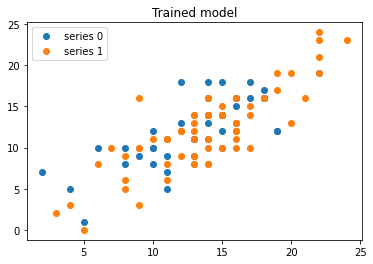

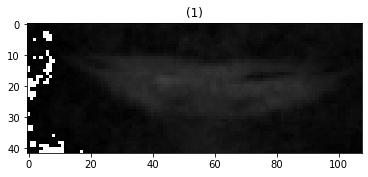

In [65]:
f = (ROI[:,:,0]-ROI[:,:,1]) + (ROI[:,:,2]-ROI[:,:,1])

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        f, 2, 2, error=0.005, maxiter=1000, init=None)

cluster_membership = np.argmax(u, axis=0)
print(cntr)
print(u)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(2):
    ax2.plot(f[0, u.argmax(axis=0) == j],
             f[1, u.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

show_images([f])

**approach 3 - YCbCr color space based**

(55, 105, 3)


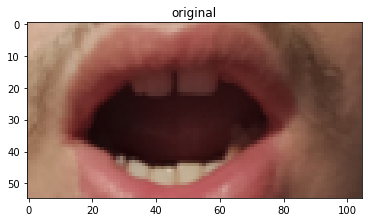

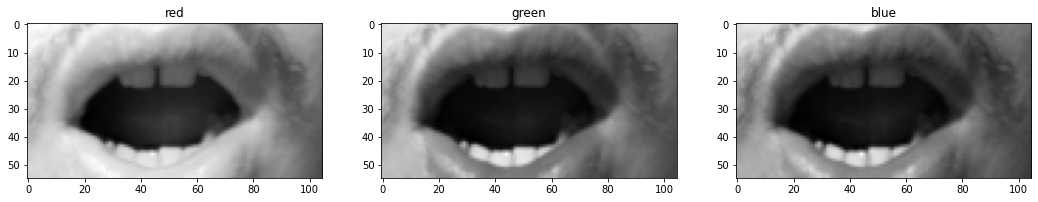

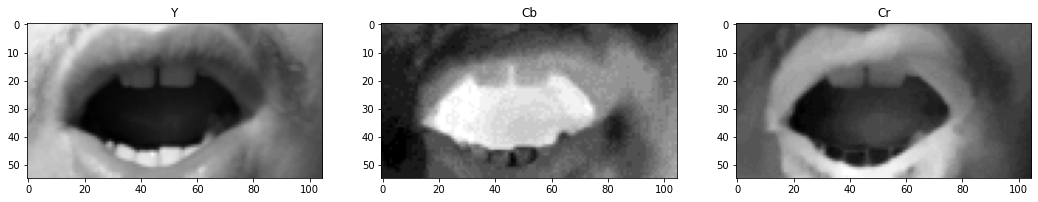

{111: 407, 110: 384, 112: 719, 109: 312, 108: 513, 113: 437, 114: 332, 115: 254, 107: 116, 116: 304, 117: 493, 118: 193, 119: 83, 120: 54, 121: 190, 122: 237, 123: 274, 124: 232, 125: 154, 106: 87}


In [16]:
print(ROI.shape)

show_images([ROI],["original"])
show_images([ROI[:,:,0],ROI[:,:,1],ROI[:,:,2]],["red","green","blue"])

ROI_Ycbcr = rgb2ycbcr(ROI)

Y = ROI_Ycbcr[:,:,0]
cb = ROI_Ycbcr[:,:,1]
cr = ROI_Ycbcr[:,:,2]

show_images([Y,cb,cr],["Y","Cb","Cr"])

#N = np.sum(cb > 100)
N1=0
s1=0
nk=dict()
for i in range(cb.shape[0]):
    for j in range(cb.shape[1]):
        if cb[i,j] < 256 and cb[i,j] >= 105:
            if cb[i,j] in nk:
                nk[cb[i,j]]+=1
            else:
                nk[cb[i,j]]=1
        
        # for k in range(105,256):
        #     if cb[i,j] == k and (k not in nk):
        #         nk[k] = 1
        #     elif  cb[i,j] == k:
        #         nk[k]+=1
             
print(nk)


In [181]:
print(ROI.shape)
ROI_Ycbcr = rgb2ycbcr(ROI)

Y = ROI_Ycbcr[:,:,0]
cb = ROI_Ycbcr[:,:,1]
cr = ROI_Ycbcr[:,:,2]

#N = np.sum(cb > 100)
 
N1=0
s1=0
nk=dict()
for k in range(95,256):
    temp = cb == k
    sum_value = np.sum(temp)
    nk[k]=sum_value
    
print(nk)


(63, 108, 3)
{95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 6, 101: 17, 102: 44, 103: 117, 104: 74, 105: 96, 106: 160, 107: 337, 108: 524, 109: 475, 110: 670, 111: 722, 112: 780, 113: 485, 114: 514, 115: 351, 116: 260, 117: 425, 118: 320, 119: 233, 120: 112, 121: 40, 122: 33, 123: 8, 124: 1, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140: 0, 141: 0, 142: 0, 143: 0, 144: 0, 145: 0, 146: 0, 147: 0, 148: 0, 149: 0, 150: 0, 151: 0, 152: 0, 153: 0, 154: 0, 155: 0, 156: 0, 157: 0, 158: 0, 159: 0, 160: 0, 161: 0, 162: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 168: 0, 169: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0, 178: 0, 179: 0, 180: 0, 181: 0, 182: 0, 183: 0, 184: 0, 185: 0, 186: 0, 187: 0, 188: 0, 189: 0, 190: 0, 191: 0, 192: 0, 193: 0, 194: 0, 195: 0, 196: 0, 197: 0, 198: 0, 199: 0, 200: 0, 201: 0, 202: 0, 203: 0, 204: 0, 205: 0, 206: 0, 207: 0, 208: 0, 209: 0, 210: 0, 211: 0, 212: 0, 213: 0, 2

In [182]:
#lip color and color of skin of Cb component are more than 100
# ni : number of pixels who’s value is i
#N : the number of pixels who’s grey value is greater than a certain gray level

N1 = sum(nk.values())

S1 = sum([key * value for key,value in nk.items()])

t1 = S1 / N1


In [183]:
N2=0
s2=0
nk=dict()
for i in range(cr.shape[0]):
    for j in range(cr.shape[1]):
        for k in range(140,256):
            if cr[i,j] == k and (k not in nk):
                nk[k] = 1
            elif  cr[i,j] == k:
                nk[k]+=1

print(nk)

{155: 550, 154: 218, 153: 397, 156: 188, 157: 269, 158: 308, 159: 215, 160: 316, 163: 315, 162: 291, 161: 201, 165: 344, 166: 128, 164: 144, 169: 55, 168: 61, 171: 52, 170: 42, 167: 122, 172: 56, 175: 53, 173: 33, 152: 243, 176: 34, 177: 28, 182: 64, 181: 49, 180: 53, 179: 45, 174: 40, 178: 40, 183: 33, 184: 30, 185: 29, 186: 13, 187: 5, 147: 67, 146: 62, 148: 80, 150: 148, 151: 121, 143: 102, 142: 99, 144: 74, 145: 92, 140: 100, 149: 60, 141: 70}


In [184]:
N2 = sum(nk.values())

S2 = sum([key * value for key,value in nk.items()])

t2 = S2 / N2

In [185]:
thresh1 = int((t1 + t2)/2)
thresh2 = int(t2)
print(thresh1)
print(thresh2)

135
158


In [186]:
cbcr_avg = np.uint8((np.int16(cb)+np.int16(cr))/2)

cbcr_avg_binary = cbcr_avg > thresh1
cr_binary = cr > thresh2
lip_noisy = np.logical_and(cbcr_avg_binary,cr_binary)

lip_cleaned = opening(lip_noisy,selem=square(5))

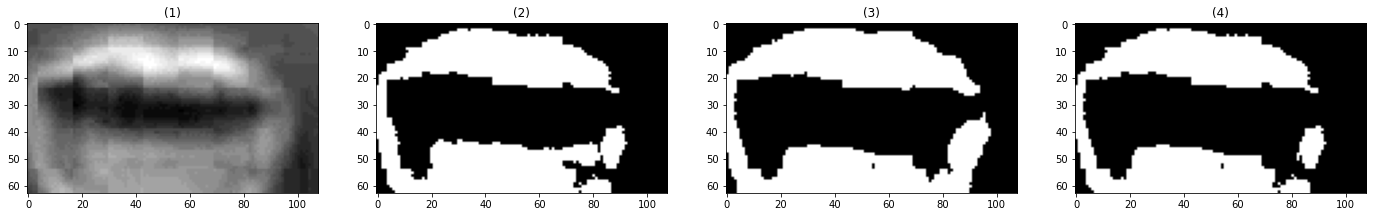

In [187]:
show_images([cbcr_avg,cbcr_avg_binary,cr_binary,lip_noisy])

In [188]:

print(np.sum(lip_noisy))
print(lip_noisy.shape)


2489
(63, 108)


## Get final outer contour

In [189]:
# print(lip_cleaned.shape)
# lip_cleaned = resize(lip_cleaned,(64,64,3))
lip_noisy.resize((64,64))
lip_cleaned = np.uint8(lip_noisy*255) # convert the clean image into uint8


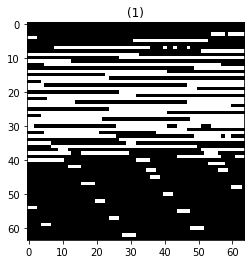

In [190]:
show_images([lip_noisy])

In [161]:
contours, hierarchy = cv2.findContours(lip_cleaned, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)     # get cnts of the cleaned image
contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area
print(len(contours))
largest_cnts=contours[0:2] # largest cnt
final_img = np.zeros((lip_cleaned.shape[0],lip_cleaned.shape[1],3)) # create 

inside = contourIntersect(largest_cnts[0],largest_cnts[1]) 

print(inside)
if inside>0:
    connected=True
else:
    connected=False

if connected:
    x1,y1,w1,h1 = cv2.boundingRect(largest_cnts[0])     
    cv2.rectangle(final_img,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)
    final_width = w1
    final_height = h1
else:
    x1,y1,w1,h1 = cv2.boundingRect(largest_cnts[0])     
    cv2.rectangle(final_img,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

    x2,y2,w2,h2 = cv2.boundingRect(largest_cnts[1])
    cv2.rectangle(final_img,(x2,y2),(x2+w2,y2+h2),(0,0,255),1)

    minx=min([x1,x2])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
    maxx=max([x1+w1,x2+w2])
    miny=min([y1,y2])
    maxy=max([y1+h1,y2+h2])
    final_width = maxx-minx
    final_height = maxy-miny

show_images([final_img,lip_cleaned])

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [159]:
#calculate H/L
print(final_height,final_width)
print(final_img.shape[0],final_img.shape[1])
final_feature =  (final_height)/(final_width)
print("height / width = : ", final_feature )

61 93
63 108
height / width = :  0.6559139784946236
